In [1]:
import pandas as pd
import numpy as np
from scipy import stats

In [ ]:
df = pd.read_csv('data_vix.csv')
# Set Date as index
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)
print(df.head())

            Close   Contract  Year ContractSymbol_x ContractSymbol1  \
Date                                                                  
2014-01-24  16.21  CFE_VX_G4  2014            VX/G4      VX/G4_2014   
2014-01-27  16.09  CFE_VX_G4  2014            VX/G4      VX/G4_2014   
2014-01-28  15.19  CFE_VX_G4  2014            VX/G4      VX/G4_2014   
2014-01-29  16.40  CFE_VX_G4  2014            VX/G4      VX/G4_2014   
2014-01-30  16.65  CFE_VX_G4  2014            VX/G4      VX/G4_2014   

           ContractSymbol_y  Expiration  SettlementPrice  DaysToExpiry  \
Date                                                                     
2014-01-24       VX/G4_2014  19/02/2014            15.47            26   
2014-01-27       VX/G4_2014  19/02/2014            15.47            23   
2014-01-28       VX/G4_2014  19/02/2014            15.47            22   
2014-01-29       VX/G4_2014  19/02/2014            15.47            21   
2014-01-30       VX/G4_2014  19/02/2014            15.47  

C:\Users\annpe\AppData\Local\Temp\ipykernel_18016\140048163.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df.index = pd.to_datetime(df.index)


In [11]:
def run_multiple_equity_strategies(df, signal_cols=None, dfl=0.25, initial_equity=1000):
    """
    Run 5 equity strategies:
    1-3: Based on signals in specified columns (names will be used in equity column names).
    4: Always long (+1 signal).
    5: Always short (-1 signal).

    Parameters:
        df (pd.DataFrame): DataFrame with required columns.
        signal_cols (list of str): List of 3 column names for signals.
        dfl (float): Directional leverage factor.
        initial_equity (float): Starting equity.

    Returns:
        pd.DataFrame: Original DataFrame + 5 new equity columns.
    """
    df = df.copy()

    if signal_cols is None:
        signal_cols = ['SV_signal', 'LSTM_signal', 'SV_LSTM_signal']

    for col in signal_cols:
        equity_col = f'Equity_{col}'
        df[equity_col] = initial_equity

        for t in range(1, len(df)):
            prev_idx = df.index[t - 1]
            curr_idx = df.index[t]

            prev_close = df.loc[prev_idx, 'Close']
            curr_close = df.loc[curr_idx, 'Close']
            prev_settlement = df.loc[prev_idx, 'SettlementPrice']
            prev_dte = df.loc[prev_idx, 'DaysToExpiry']
            signal = df.loc[prev_idx, col]
            prev_equity = df.loc[prev_idx, equity_col]

            if prev_dte > 1:
                ret = (curr_close / prev_close) - 1
            else:
                ret = (prev_settlement / prev_close) - 1

            df.loc[curr_idx, equity_col] = prev_equity * (1 + dfl * signal * ret)

    # Strategy 4: Always long
    df['Equity_Always_Long'] = initial_equity
    # Strategy 5: Always short
    df['Equity_Always_Short'] = initial_equity

    for t in range(1, len(df)):
        prev_idx = df.index[t - 1]
        curr_idx = df.index[t]

        prev_close = df.loc[prev_idx, 'Close']
        curr_close = df.loc[curr_idx, 'Close']
        prev_settlement = df.loc[prev_idx, 'SettlementPrice']
        prev_dte = df.loc[prev_idx, 'DaysToExpiry']

        if prev_dte > 1:
            ret = (curr_close / prev_close) - 1
        else:
            ret = (prev_settlement / prev_close) - 1

        df.loc[curr_idx, 'Equity_Always_Long'] = df.loc[prev_idx, 'Equity_Always_Long'] * (1 + dfl * 1 * ret)
        df.loc[curr_idx, 'Equity_Always_Short'] = df.loc[prev_idx, 'Equity_Always_Short'] * (1 + dfl * -1 * ret)

    return df


In [46]:
def run_multiple_equity_strategies_with_cost(df, signal_cols=None, dfl=0.25, initial_equity=1000, transaction_cost=0.001):
    """
    Run 5 equity strategies:
    1-3: Based on signals in specified columns (names will be used in equity column names).
    4: Always long (+1 signal).
    5: Always short (-1 signal).

    Transaction costs are applied proportional to the size of position changes (turnover).

    Parameters:
        df (pd.DataFrame): DataFrame with required columns.
        signal_cols (list of str): List of 3 column names for signals.
        dfl (float): Directional leverage factor.
        initial_equity (float): Starting equity.
        transaction_cost (float): Transaction cost per unit turnover (e.g., 0.0001 = 0.01%).

    Returns:
        pd.DataFrame: Original DataFrame + 5 new equity columns.
    """
    df = df.copy()

    if signal_cols is None:
        signal_cols = ['SV_signal', 'LSTM_signal', 'SV_LSTM_signal']

    for col in signal_cols:
        equity_col = f'Equity_{col}'
        df[equity_col] = initial_equity

        for t in range(1, len(df)):
            prev_idx = df.index[t - 1]
            curr_idx = df.index[t]

            prev_close = df.loc[prev_idx, 'Close']
            curr_close = df.loc[curr_idx, 'Close']
            prev_settlement = df.loc[prev_idx, 'SettlementPrice']
            prev_dte = df.loc[prev_idx, 'DaysToExpiry']

            prev_signal = df.loc[prev_idx, col]
            curr_signal = df.loc[curr_idx, col]
            prev_equity = df.loc[prev_idx, equity_col]

            # Calculate return depending on DaysToExpiry
            if prev_dte > 1:
                ret = (curr_close / prev_close) - 1
            else:
                ret = (prev_settlement / prev_close) - 1

            # Calculate turnover: absolute change in position size (signal)
            turnover = abs(curr_signal - prev_signal)

            # Calculate transaction cost proportional to turnover and previous equity
            cost = prev_equity * transaction_cost * turnover

            # Update equity after returns and transaction cost
            equity_after_return = prev_equity * (1 + dfl * prev_signal  * ret)
            df.loc[curr_idx, equity_col] = equity_after_return - cost

    # Strategy 4: Always long (+1)
    df['Equity_Always_Long'] = initial_equity
    # Strategy 5: Always short (-1)
    df['Equity_Always_Short'] = initial_equity

    for t in range(1, len(df)):
        prev_idx = df.index[t - 1]
        curr_idx = df.index[t]

        prev_close = df.loc[prev_idx, 'Close']
        curr_close = df.loc[curr_idx, 'Close']
        prev_settlement = df.loc[prev_idx, 'SettlementPrice']
        prev_dte = df.loc[prev_idx, 'DaysToExpiry']

        if prev_dte > 1:
            ret = (curr_close / prev_close) - 1
        else:
            ret = (prev_settlement / prev_close) - 1

        # Always long strategy - signal always 1
        prev_equity_long = df.loc[prev_idx, 'Equity_Always_Long']
        turnover_long = 0  # no position change, always long
        cost_long = prev_equity_long * transaction_cost * turnover_long
        equity_long = prev_equity_long * (1 + dfl * 1 * ret) - cost_long
        df.loc[curr_idx, 'Equity_Always_Long'] = equity_long

        # Always short strategy - signal always -1
        prev_equity_short = df.loc[prev_idx, 'Equity_Always_Short']
        turnover_short = 0  # no position change, always short
        cost_short = prev_equity_short * transaction_cost * turnover_short
        equity_short = prev_equity_short * (1 + dfl * -1 * ret) - cost_short
        df.loc[curr_idx, 'Equity_Always_Short'] = equity_short

    return df

In [43]:
df_with_equity = run_multiple_equity_strategies(df)

C:\Users\annpe\AppData\Local\Temp\ipykernel_18016\1896533864.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1001.8507094386182' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[curr_idx, equity_col] = prev_equity * (1 + dfl * signal * ret)
C:\Users\annpe\AppData\Local\Temp\ipykernel_18016\1896533864.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1001.8507094386182' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[curr_idx, equity_col] = prev_equity * (1 + dfl * signal * ret)
C:\Users\annpe\AppData\Local\Temp\ipykernel_18016\1896533864.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1001.8507094386182' has dtype incompatible with int

In [47]:
df_with_equity = run_multiple_equity_strategies_with_cost(df)

C:\Users\annpe\AppData\Local\Temp\ipykernel_18016\1811462579.py:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '999.8507094386182' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[curr_idx, equity_col] = equity_after_return - cost
C:\Users\annpe\AppData\Local\Temp\ipykernel_18016\1811462579.py:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '999.8507094386182' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[curr_idx, equity_col] = equity_after_return - cost
C:\Users\annpe\AppData\Local\Temp\ipykernel_18016\1811462579.py:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '999.8507094386182' has dtype incompatible with int64, please explicitly cast 

<Axes: xlabel='Date'>

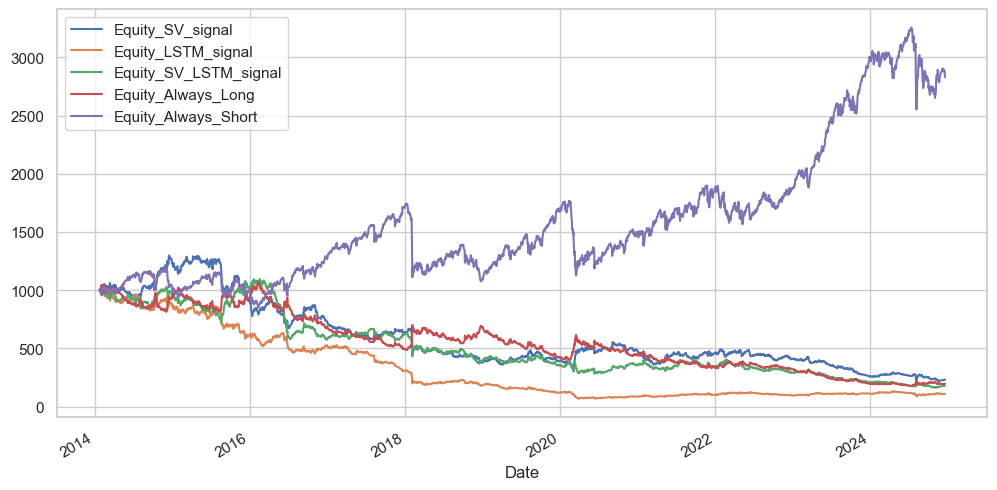

In [48]:
df_with_equity[['Equity_SV_signal', 'Equity_LSTM_signal', 'Equity_SV_LSTM_signal',
                'Equity_Always_Long', 'Equity_Always_Short']].plot(figsize=(12, 6))


In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_equity_strategies(df):
    """
    Plot 5 equity strategy curves from the DataFrame with a clean style.
    Assumes equity columns are named:
        'Equity_SV_signal', 'Equity_LSTM_signal', 'Equity_SV_LSTM_signal',
        'Equity_Always_Long', 'Equity_Always_Short'
    """

    plt.figure(figsize=(12, 6))
    sns.set(style="whitegrid")

    # Plot with labels, colors, and styles
    plt.plot(df.index, df['Equity_SV_signal'], label='SV Signal Strategy', color="navy", linewidth=1.0)
    plt.plot(df.index, df['Equity_LSTM_signal'], label='LSTM Signal Strategy', color="darkorange", linewidth=1.0)
    plt.plot(df.index, df['Equity_SV_LSTM_signal'], label='SV-LSTM Hybrid Strategy', color="darkviolet",linewidth=1.0)
    plt.plot(df.index, df['Equity_Always_Long'], label='Naive Long', color="g", linewidth=1.0)
    plt.plot(df.index, df['Equity_Always_Short'], label='Naive Short', color="crimson", linewidth=1.0)

    # Formatting
    plt.title('Equity Curve Comparison of Strategies', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Equity Value', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(loc='upper left', frameon=True)
    plt.tight_layout()

    plt.show()

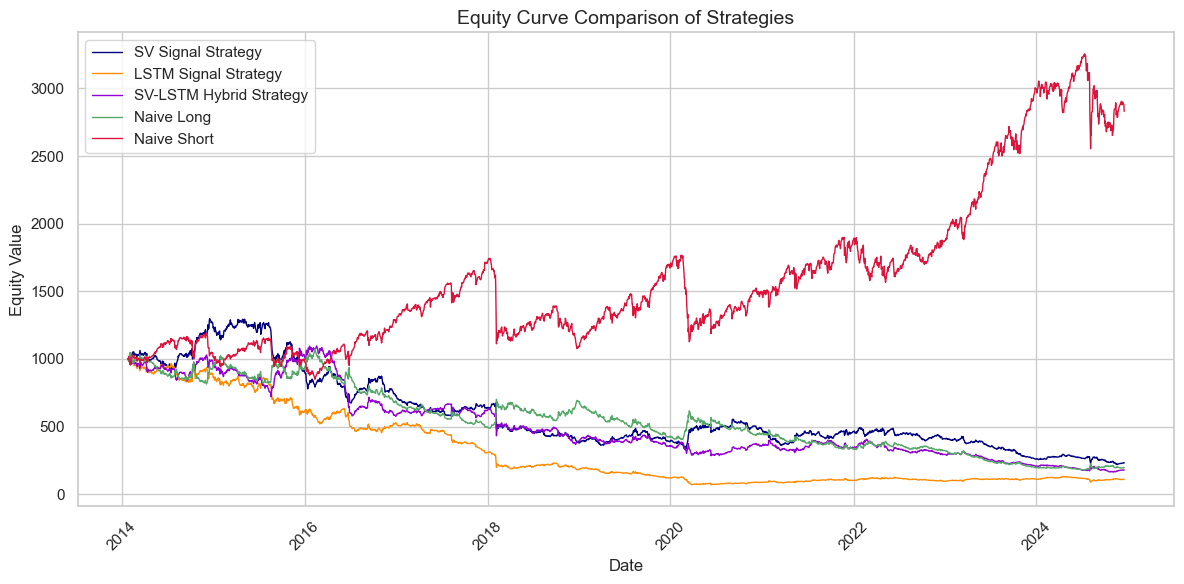

In [50]:
plot_equity_strategies(df_with_equity)

In [51]:
print(df_with_equity)

            Close    Contract  Year ContractSymbol_x ContractSymbol1  \
Date                                                                   
2014-01-24  16.21   CFE_VX_G4  2014            VX/G4      VX/G4_2014   
2014-01-27  16.09   CFE_VX_G4  2014            VX/G4      VX/G4_2014   
2014-01-28  15.19   CFE_VX_G4  2014            VX/G4      VX/G4_2014   
2014-01-29  16.40   CFE_VX_G4  2014            VX/G4      VX/G4_2014   
2014-01-30  16.65   CFE_VX_G4  2014            VX/G4      VX/G4_2014   
...           ...         ...   ...              ...             ...   
2024-12-11  14.36  CFE_VX_Z24  2024           VX/Z24      VX/Z4_2024   
2024-12-12  14.51  CFE_VX_Z24  2024           VX/Z24      VX/Z4_2024   
2024-12-13  14.55  CFE_VX_Z24  2024           VX/Z24      VX/Z4_2024   
2024-12-16  14.75  CFE_VX_Z24  2024           VX/Z24      VX/Z4_2024   
2024-12-17  15.75  CFE_VX_Z24  2024           VX/Z24      VX/Z4_2024   

           ContractSymbol_y  Expiration  SettlementPrice  DaysT

In [52]:
def calculate_metrics(df, equity_cols, benchmark_col='Equity_Always_Long', trading_days=252):
    results = {}

    for col in equity_cols:
        equity = df[col].dropna()
        returns = equity.pct_change().dropna()

        total_periods = len(returns)
        total_years = total_periods / trading_days
        annualized_return = (equity.iloc[-1] / equity.iloc[0]) ** (1 / total_years) - 1
        annualized_std = returns.std() * np.sqrt(trading_days)
        sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(trading_days)
        running_max = equity.cummax()
        drawdowns = (equity - running_max) / running_max
        max_drawdown = drawdowns.min()
        calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else np.nan

        # Information Ratio calculation
        if col == benchmark_col:
            information_ratio = np.nan  # or 0, depending on your preference
        else:
            benchmark_equity = df[benchmark_col].dropna()
            benchmark_returns = benchmark_equity.pct_change().dropna()
            common_idx = returns.index.intersection(benchmark_returns.index)
            excess_returns = returns.loc[common_idx] - benchmark_returns.loc[common_idx]

            if excess_returns.std() > 0:
                information_ratio = (excess_returns.mean() / excess_returns.std()) * np.sqrt(trading_days)
            else:
                information_ratio = np.nan

        results[col] = {
            'Annualized Return (%)': annualized_return * 100,
            'Annualized Std Dev (%)': annualized_std * 100,
            'Sharpe Ratio': sharpe_ratio,
            'Max Drawdown (%)': max_drawdown * 100,
            'Calmar Ratio': calmar_ratio,
            'Information Ratio': information_ratio
        }

    return pd.DataFrame(results).T

In [53]:
# Example usage
equity_columns = ['Equity_SV_signal', 'Equity_LSTM_signal', 'Equity_SV_LSTM_signal', 'Equity_Always_Long', 'Equity_Always_Short']
metrics_df = calculate_metrics(df_with_equity, equity_columns)
print(metrics_df)

                       Annualized Return (%)  Annualized Std Dev (%)  \
Equity_SV_signal                  -12.490734               22.886942   
Equity_LSTM_signal                -18.311690               23.069431   
Equity_SV_LSTM_signal             -14.573902               23.070816   
Equity_Always_Long                -13.816038               22.961166   
Equity_Always_Short                10.029413               22.961166   

                       Sharpe Ratio  Max Drawdown (%)  Calmar Ratio  \
Equity_SV_signal          -0.464412        -83.107245     -0.150297   
Equity_LSTM_signal        -0.756669        -93.367925     -0.196124   
Equity_SV_LSTM_signal     -0.563392        -85.150028     -0.171156   
Equity_Always_Long        -0.536248        -83.352424     -0.165754   
Equity_Always_Short        0.536248        -38.274361      0.262040   

                       Information Ratio  
Equity_SV_signal                0.047323  
Equity_LSTM_signal             -0.137911  
Equity_SV_L

In [54]:
def calculate_total_return(df, equity_column):
    start_value = df[equity_column].iloc[0]
    end_value = df[equity_column].iloc[-1]
    total_return = (end_value / start_value - 1) * 100  # in percentage
    return total_return

In [57]:
def calculate_total_returns(df, equity_columns):
    total_returns = {}
    for col in equity_columns:
        start_value = df[col].iloc[0]
        end_value = df[col].iloc[-1]
        total_return = (end_value / start_value - 1) * 100  # percentage
        total_returns[col] = total_return
    return total_returns

# Example usage:
equity_cols = [
    'Equity_SV_signal', 
    'Equity_LSTM_signal', 
    'Equity_SV_LSTM_signal', 
    'Equity_Always_Long', 
    'Equity_Always_Short'
]

total_returns = calculate_total_returns(df_with_equity, equity_cols)
for strategy, ret in total_returns.items():
    print(f"{strategy}: {ret:.2f}%")

Equity_SV_signal: -76.60%
Equity_LSTM_signal: -88.94%
Equity_SV_LSTM_signal: -82.00%
Equity_Always_Long: -80.18%
Equity_Always_Short: 183.02%
